# Getting insights about businesses and locations from Google Maps

![image](https://i.ibb.co/Pzrs73R/cover.png)

Google Maps is full of useful data about any type of business or location you're interested in. In this step by step article, I'm going to use **Python** and **Selenium** to extract data from it about a business (or location, we'll look into 3 main examples), and then do the same to the similar or competing businesses in close proximity to it, all in a quick and automated way.

The output of this operation is a **Dataframe** containing useful data (names, business types, star ratings, contact info, coordinates, popular hours, etc.) that we can use to derive many insights about the business/location and its surrounding environments.

This is going to be useful if you want to get an idea about where your competitors stand, but also if you want a quick way to generate a listing of a certain type of business in any given city. It also works for historical landmarks, parks and all sorts of attractions, not just businesses as we will see later in the 3rd and last example.

You can follow along with this article by downloading the Jupyter Notebook for it in my [**GitHub repository here**]() (where the code is explained in much more detail).

*ps: I'm not affiliated to any business. Examples in this article are taken at random for illustrative and educational purposes only.*

---

# The packages and the setup :

![image](https://i.ibb.co/tZC4cQc/packages.png)

Illustration by Minty - rawpixel.com

We’ll need the [**Selenium**](https://pypi.org/project/selenium/) python package to perform the data scraping. If you don’t have it yet, you can install it using pip: `pip install selenium` or `conda install selenium` if you're using an Anaconda distribution.

We’ll also need a **WebDriver** in order to interact with the browser (we'll use Chrome here), so you have to [**go here and download it**](https://chromedriver.chromium.org/downloads) to your machine (make sure it’s compatible with your current Chrome version) :

In [2]:
from selenium import webdriver

We'll also need a couple of useful classes from Selenium. We'll import them here :

In [3]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementNotInteractableException, ElementClickInterceptedException

Now let’s get [**tqdm**](https://github.com/tqdm/tqdm), an essential progress bar python package. It is very useful to estimate how much time the web scraping part of your code will take (i’m using tqdm_notebook because I’m working in a Jupyter Notebook. In IDEs you should do `from tqdm import tqdm` and then use `tqdm` instead of `tqdmn`) :

In [4]:
from tqdm import tqdm_notebook as tqdmn

In addition to that, we’ll need [**Pandas**](https://pandas.pydata.org/) to read and manipulate the dataset, and [**Numpy**](https://numpy.org/) to deal with null values :

In [5]:
import pandas as pd
import numpy as np

Also, let's import [**Matplotlib**](https://matplotlib.org/) and [**Seaborn**](https://seaborn.pydata.org/) to do data visualisations :

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In order to visualise our businesses/locations in a map, we'll need [**Folium**](https://pypi.org/project/folium). If you don't have Folium, install it using `pip install folium` or `conda install -c conda-forge folium` :

In [7]:
import folium

Finally, we'll need the built-in python modules [**time**](https://docs.python.org/3/library/time.html) and [**re**]() (the first to stop the code for a certain time while elements load, and the second to extract data from raw text in patterns using [**RegEx or Regular Expressions**](https://regexr.com/)): 

In [8]:
import time, re

This is optional, just to add some CSS styling to our dataframes :

In [34]:
%%HTML
<style>.dataframe th,td:first-child{background: rgb(63,87,124);background: linear-gradient(180deg, rgba(63,87,124,1) 0%, rgba(101,124,161,1) 100%, rgba(0,212,255,1) 100%);;
padding: 10px;font-family: monospace;font-size: 110%;color: white;border:1px dashed white;text-align:left !important;
-moz-border-radius: 3x;-webkit-border-radius: 3px;}.dataframe thead{border:none; !important;}</style>

---

# Print shops in Brisbane, Australia :

![Brisbane](https://i.ibb.co/CBHYXRg/brisbane.png)

Picture by Brad Scruse - Flickr.com (CC)

Ryan is a fresh graduate with a diploma in Print Industry Management and he's looking for a job in Brisbane, Australia. He just sent his resume to the print shop **Kwik Kopy Brisbane** (because it happened to be the closest to his home). Where else can he find a suitable job in the city? Let's help Ryan out.

First thing we do is go to Google Maps and search for the name of that business, or we can add the name after `www.google.com/maps/search/` in the address bar of our browser. Then, if we click on the business category, here `Print shop` (see image bellow), we get a listing of different print related businesses. The longer we navigate, the farther we get from the location of our initial Print shop :

![image](https://i.ibb.co/zfv2bJk/competition.png)

Before writing the code that will do the web scraping for us, let's lay out all the steps we'll go through :

**1. Rounding the competition** : <br>
* A : Taking the name of our business and adding it after `www.google.com/maps/search/` and then visiting that URL
* B : Clicking on the business category
* C : Capturing the names and addresses of the competitors, then clicking the next button `>`. We do this repeatedly until we're satisfied with how many competitors we got. The output of this step is a **list** of competitors (names and addresses), let's names it `competition` (names alone are not enough to uniquely identify a business, that's why we also capture addresses)

**2. Extracting the data** : <br>
* D : Taking the first element of `competition` and adding it after `www.google.com/maps/search/` and then visiting that URL
* E : extracting the name, business category, average rating, total number of reviews, address, phone number and website, then loop again to step D with another element from `competition` until the end.

Here's the code to do so :

In [337]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ :
driver = webdriver.Chrome("C:\\chromedriver.exe")

# This is the list where we'll capture the competitors' names and addresses
competition = []

# [STEP A] : The name and location of the initial print shop that will go into the search URL
starting_business = 'Kwik Kopy Brisbane'
city = 'Brisbane'
url = 'https://www.google.com/maps/search/' + starting_business + ' ' + city

# [STEP A] : Opening the search URL. You'll notice a chrome window opening :
driver.get(url)

# Waiting for the name of the business to load and be visible :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))

# [STEP B] : Clicking on the business category :
driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').click()

# Waiting for the results to appear :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))
        
# [STEP C] : We repeat the code below 5 times (if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(5), leave=False, desc='1. Rounding the competition' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names and addresses of the competitors and adding them to our list 'competition' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        competition.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it (if it's not clickable, we break the for loop) :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the competition list (because they'll break URLs) :
competition = [i.replace('/', ' ') for i in competition]

# These are the empty lists we will populate with the extracted data in the 2nd phase :
full_name = []
rating = []
total_ratings = []
business_cat = []
address = []
phone = []
website = []
lat = []
long = []
    
# Here's the big loop iterating over the competiton list :
for business in tqdmn(competition, leave=False, desc='2. Extracting the data') :
    
    # [STEP D] :
    url = 'https://www.google.com/maps/search/' + business
    driver.get(url)

    # Waiting for the name of the business to load and be visible. If it fails, skip to next business in competition list :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # [STEP E] : Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        business_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        business_cat.append(np.nan)
    
    try:
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copy address"]').text)
    except NoSuchElementException :
        address.append(np.nan)
    
    try:
        phone.append(driver.find_element_by_css_selector('div[data-tooltip="Copy phone number"]').text)
    except NoSuchElementException :
        phone.append(np.nan)

    try:
        website.append(driver.find_element_by_css_selector('div[data-tooltip="Open website"]').text)
    except NoSuchElementException :
        website.append(np.nan)
    
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

After executing this code, you'll see a Chrome window open and the steps we outlined before execute one after the other automatically. From time to time, **Google Maps will confuse a business name/address with another**, and give you a choice :

![image](https://i.ibb.co/YLY25Z2/miss.png)

When this happens, simply click on the business closest to the query in the search bar, and the code will continue normally. You can also just ignore it and the code will skip to the next iteration in `competition` on its own after 25 seconds (so just go make that cup of tea while the code runs).

If all worked as planned, let's make a pandas dataframe out of the lists we have extracted. Let's call it `PS` for Print Shops :

In [338]:
PS = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings,
                                  'business_category':business_cat, 'address':address, 'phone':phone, 'website':website, 
                                 'latitude':lat, 'longitude':long})

And here's our dataframe containing info on Kwik Kopy and around a hundred of its competitors :

In [339]:
PS.head()

,full_name,rating,total_ratings,business_category,address,phone,website,latitude,longitude
0,Kwik Kopy Brisbane,4.3,(20),Print shop,"Emirates House, Level 19/167 Eagle St, Brisban...",+61 7 3229 9988,kwikkopy.com.au,-27.4660628,153.0305382
1,Worldwide Edward Street BRISBANE CBD,5.0,(42),Print shop,"Level 4 Rowes Building, 235, Edward St, Brisba...",+61 7 3229 8522,worldwide.com.au,-27.467671,153.026695
2,Copy Cat Printing and Signage,4.4,(36),Print shop,"109/101 Wickham Terrace, Spring Hill QLD 4000,...",+61 7 3831 4766,copycatprint.com.au,-27.464356,153.0262079
3,PostNet Brisbane CBD,4.9,(46),Print shop,"Anzac Square Arcade, PostNet Brisbane CBD Shop...",+61 7 3157 2776,NaN,-27.4670389,153.0264034
4,Worldwide Charlotte Street,4.7,(25),Print shop,"Ground Floor, Shop 2/119 Charlotte St, Brisban...",+61 7 3210 1110,worldwide.com.au,-27.470865,153.027357


At this point, it is a good idea to save this dataframe as a CSV file for safe keeping :

In [340]:
PS.to_csv('print_shops.csv', index=False)

Next time we open the notebook, all we have to do is read the CSV file instead of running the web scraping code all over again :

In [35]:
PS = pd.read_csv('print_shops.csv')

In [36]:
PS.shape

(113, 9)

Let's see how many different business categories we got :

In [37]:
PS.business_category.value_counts()

Print shop                        70
Commercial printer                14
Graphic designer                   6
Digital printing service           3
Sign shop                          3
Pen store                          2
Business management consultant     1
Glass & mirror shop                1
Art studio                         1
Banner store                       1
Office equipment supplier          1
Photo restoration service          1
Marketing agency                   1
Website designer                   1
Office supply store                1
Computer store                     1
Screen printing shop               1
Photo lab                          1
画廊                                 1
Toner cartridge supplier           1
Pizza restaurant                   1
Name: business_category, dtype: int64

In this case, most businesses we got are **Print shops** and **Commercal printers**. These are the two main business categories that interest Ryan in our case. Let's get rid of the rest :

In [38]:
PS = PS[PS.business_category.isin(['Print shop', 'Commercial printer'])].copy()

In [39]:
PS.business_category.value_counts()

Print shop            70
Commercial printer    14
Name: business_category, dtype: int64

That's 84 different businesses Ryan can consider when looking for a job. Not bad! But how spread out are they in the city? To answer this question, let's map them out and add their info on a popup that shows up when a marker is clicked :

In [42]:
from IPython.display import IFrame

PS_map = folium.Map( [-27.4,153], tiles='CartoDB positron' )

for latitude, longitude, full_name, address, phone, website, rating, total_rating in zip(PS.latitude, PS.longitude, PS.full_name, PS.address, PS.phone, PS.website, PS.rating, PS.total_ratings):
    popup = '<strong>' + str(full_name) + '</strong><br><br><ul><li>' + str(address) + '</li><li>' + str(phone) + '</li><li>' + str(website) + '</li><li>Rating: ' + str(rating) + ' (Total of ' + str(total_rating) + ' reviews)'
    folium.Marker( [latitude, longitude], 
                   icon=folium.CustomIcon( icon_image='https://i.imgur.com/CYx04oC.png', icon_size=(10,10) ), popup=popup).add_to(PS_map)

PS_map.save('PS_map.html')
IFrame(src='PS_map.html', width='100%', height=500)

Now this looks more like a road map for a job hunt adventure! Ryan can start contacting the nearest businesses to his home and spread outwards if need be.

In this use case, the average rating and the total number of ratings have very little significance to Ryan. In the next example, we'll explore businesses in a sector where these two variables holds much more weight: we'll look for the best steak houses in the lively city of Glasgow.

---

# Steak houses in Glasgow, Scotland :

![Glasgow](https://i.ibb.co/LNYcdjg/glasgow.png)

Photo by Dave Shea - Flickr.com (CC)

Moira wants to treat her boyfriend to a good steak dinner as a birthday gift, but she doesn't know where to go in particular. She searched in a specialised blog and found **Mini Grill Steakhouse** to be one of the best in Glasgow. Let's help Moira decide which Steak house would be best for the occasion, knowing that she thinks that good **wine** (or cocktails) and **music** are a must for a good experience.

We'll follow exactly the same steps as before, except for the addition of two new types of useful info: the **price range** (goes from `$` to `$$$$`) and the **review topics** (the numbers refer to how many reviews spoke about that topic) :

![image](https://i.ibb.co/CQf2WMn/reviews.png)

And here's the code we'll use (sometimes Google Maps does not show review topics at all. If that happened, just close the Chrome window, stop the code and re-run the cell again) :

In [98]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ : :
driver = webdriver.Chrome("C:\\chromedriver.exe")

# This is the list where we'll capture the competitors' names and addresses
competition = []

# [STEP A] : The name and location of the initial steak house that will go into the search URL
starting_business = 'Mini Grill Steakhouse'
city = 'Glasgow'
url = 'https://www.google.com/maps/search/' + starting_business + ' ' + city

# [STEP A] : Opening the search URL. You'll notice a chrome window opening :
driver.get(url)

# Waiting for the name of the business to load and be visible :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))

# [STEP B] : Clicking on the business category :
driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').click()

# Waiting for the results to appear :
WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))
        
# [STEP C] : We repeat the code below 5 times (if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(5), leave=False, desc='1. Rounding the competition' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names and addresses of the competitors and adding them to our list 'competition' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        competition.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the competition list (because they'll break URLs) :
competition = [i.replace('/', ' ') for i in competition]

# These are the empty lists we will populate with the extracted data :
full_name = []
rating = []
total_ratings = []
business_cat = []
price_range = []
address = []
phone = []
website = []
review_topics = []
lat = []
long = []
    
# Here's the big loop iterating over the competiton list :
for business in tqdmn(competition, leave=False, desc='2. Extracting the data') :
    
    # [STEP D] :
    url = 'https://www.google.com/maps/search/' + business
    driver.get(url)

    # Waiting for the name of the business to load and be visible. If it fails, skip to next business in the competition list :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # [STEP E] : Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        business_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        business_cat.append(np.nan)
        
    try:
        price_range.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[2]/span[2]/span[1]/span').text)
    except NoSuchElementException:
        price_range.append(np.nan)
    
    try:
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copy address"]').text)
    except NoSuchElementException :
        address.append(np.nan)
    
    try:
        phone.append(driver.find_element_by_css_selector('div[data-tooltip="Copy phone number"]').text)
    except NoSuchElementException :
        phone.append(np.nan)

    try:
        website.append(driver.find_element_by_css_selector('div[data-tooltip="Open website"]').text)
    except NoSuchElementException :
        website.append(np.nan)
    
    try :
        driver.find_element_by_xpath("//*[contains(@aria-label, 'more Topics')]").click()
    except (NoSuchElementException, ElementNotInteractableException, ElementClickInterceptedException) as e:
        pass
    
    try:
        review_topics.append([i.text for i in driver.find_elements_by_xpath("//*[contains(@aria-label, 'mentioned')]")])
    except NoSuchElementException :
        review_topics.append(np.nan)
    
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

Now let's make a dataframe out of the lists we extracted. We'll name it `SH` for Steak Houses :

In [132]:
SH = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings,
                                  'business_category':business_cat, 'price_range':price_range, 'address':address, 
                        'phone':phone, 'website':website, 'review_topics':review_topics, 'latitude':lat, 'longitude':long})

We got around 100 establishments :

In [44]:
SH.head(5)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,latitude,longitude
0,Mini Grill Steakhouse - Glasgow,4.7,(567),Steak house,$$,"244A Bath St, Glasgow G2 4JW, United Kingdom",+44 141 332 2732,minigrillglasgow.co.uk,"['haggis\n23', 'burger\n22', 'scallops\n7', 'r...",55.865028,-4.265692
1,Meat Bar,4.6,(501),Steak house,$$,"142 W Regent St, Glasgow G2 2RQ, United Kingdom",+44 141 204 3605,themeatbar.co.uk,"['burgers\n41', 'cocktails\n25', 'fries\n17', ...",55.863674,-4.260043
2,"Marco Pierre White Steakhouse, Bar & Grill Gla...",3.6,(309),Steak house,$$$,"75 Waterloo St, Glasgow G2 7DA, United Kingdom",+44 141 226 7726,mpwrestaurants.co.uk,"['afternoon tea\n18', 'hotel\n13', 'chateaubri...",55.860361,-4.263138
3,Miller & Carter Glasgow,4.6,"(2,679)",Steak house,$$,"47 St Vincent St, Glasgow G2 5QX, United Kingdom",+44 141 404 2914,millerandcarter.co.uk,"['toilets\n30', 'beef dripping\n20', 'chateaub...",55.861113,-4.254384
4,Blackhouse Steakhouse Glasgow,4.1,(13),Steak house,NaN,"21 Bothwell St, Glasgow G2 6NL, United Kingdom",+44 141 248 6262,blackhouse.uk.com,[],55.860917,-4.259839


Just like before, let's save/open this dataframe as a CSV file for safe keeping (so we won't have to run the script above every time we open the notebook) :

In [133]:
SH.to_csv('steak_houses.csv', index=False)

In [43]:
SH = pd.read_csv('steak_houses.csv')

In [45]:
SH.shape

(99, 11)

Let's take a look at the business categories we got :

In [140]:
SH.business_category.value_counts()

Steak house                    25
Restaurant                     13
Italian restaurant             12
Bar & grill                     7
Indian restaurant               5
Chinese restaurant              2
British restaurant              2
Cocktail bar                    2
Pancake restaurant              2
Fast food restaurant            2
Hamburger restaurant            2
French restaurant               2
Pizza restaurant                2
Pub                             2
Vegan restaurant                1
Fish and seafood restaurant     1
Japanese restaurant             1
American restaurant             1
Country food restaurant         1
Japanese steakhouse             1
Chicken restaurant              1
Spanish restaurant              1
Chophouse restaurant            1
Event venue                     1
Night club                      1
Meat dish restaurant            1
Kebab shop                      1
Bar                             1
Brazilian restaurant            1
Turkish restau

We want to only keep the establishments that are **Steak houses**, **Bar & Grills** or **restaurants having the name 'steak' or 'grill' in their names**. Let's call this new dataframe `SBR` (for Steak houses, Bar & Grills and Restaurants) :

In [13]:
steak_houses = SH[SH.business_category == 'Steak house']
bar_grills  = SH[SH.business_category == 'Bar & grill']
restaurants  = SH[(SH.business_category.str.contains('Restaurant', case=False)) & (SH.full_name.str.contains('steak|grill', case=False, regex=True))]

SBR = pd.concat([steak_houses, bar_grills, restaurants])

In [14]:
SBR.head(2)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,latitude,longitude
0,Mini Grill Steakhouse - Glasgow,4.7,(567),Steak house,$$,"244A Bath St, Glasgow G2 4JW, United Kingdom",+44 141 332 2732,minigrillglasgow.co.uk,"['haggis\n23', 'burger\n22', 'scallops\n7', 'r...",55.865028,-4.265692
1,Meat Bar,4.6,(501),Steak house,$$,"142 W Regent St, Glasgow G2 2RQ, United Kingdom",+44 141 204 3605,themeatbar.co.uk,"['burgers\n41', 'cocktails\n25', 'fries\n17', ...",55.863674,-4.260043


That's 47 establishments to choose from!

In [173]:
SBR.shape

(47, 11)

Now let's help Moira pick the best deal from this selection of fine dining places. If you remember, Moira wants a good experience with **wine** or **cocktails** and **music**. Let's see the `review_topics` for the places that have one or more of these requirements :

In [274]:
list(SBR[SBR.review_topics.str.contains('\Wwine|cocktail|music', case=False, regex=True)].review_topics)

["['burgers\\n41', 'cocktails\\n25', 'fries\\n17', 'craft beer\\n9', 'sirloin\\n9', 'music\\n8', 'haggis\\n6', 'bacon\\n6', 'sides\\n6', 'ribs\\n5']",
 "['toilets\\n30', 'beef dripping\\n20', 'chateaubriand\\n13', 'prosecco\\n11', 'bank vault\\n7', 'butcher block\\n7', 'food and wine\\n7', 'christmas menu\\n6', 'loaf\\n6', 'architecture\\n5']",
 "['gin\\n62', 'cocktails\\n27', 'station\\n17', 'sunday roast\\n13', 'night\\n8', 'chips\\n8', 'stairs\\n6', 'medium rare\\n6', 'chocolate brownie\\n5', 'choice\\n5']",
 "['cocktails\\n18', 'chips\\n11', 'sunday roast\\n10', 'mac and cheese\\n10', 'sides\\n8', 'bone marrow\\n5', 'chateaubriand\\n5', 'beef dripping\\n5', 'dry aged\\n5', 'knife\\n5']",
 "['night\\n9', 'course\\n8', 'voucher\\n6', 'food and service\\n6', 'dining\\n6', 'cocktails\\n5', 'book\\n4', 'afternoon tea\\n3', 'groupon\\n3', 'window\\n3']",
 "['night\\n10', 'value\\n9', 'choice\\n6', 'music\\n6', 'chips\\n6', 'skewers\\n5', 'cheesecake\\n4', 'tomato\\n4', 'mussels\\n3', 'pr

As we can see above, 16 different places have at least one of the 3 keywords. To be able to make a choice, let's add 3 new columns `wine`, `cocktails` and `music` containing how many times these keywords were mentioned by the reviews (that's the number that comes after `\\n` in the extracted `review_topics`. We are NOT counting how many these words are mentioned). We'll use RegEx to extract the info we want: first we extract the part `'wine\\n8'` with `wine......|$`, and then we take out the number using `\d+|$`. `|$` here insures we get an empty value if the patterns are not there :

In [15]:
wine = []
for i in SBR.review_topics :
    wine.append(re.findall('\d+|$', re.findall('wine......|$', i)[0])[0] )

SBR['wine'] = wine

cocktail = []
for i in SBR.review_topics :
    cocktail.append(re.findall('\d+|$', re.findall('cocktail......|$', i)[0])[0] )

SBR['cocktail'] = cocktail

music = []
for i in SBR.review_topics :
    music.append(re.findall('\d+|$', re.findall('music......|$', i)[0])[0] )

SBR['music'] = music

In [16]:
SBR.head(2)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,latitude,longitude,wine,cocktail,music
0,Mini Grill Steakhouse - Glasgow,4.7,(567),Steak house,$$,"244A Bath St, Glasgow G2 4JW, United Kingdom",+44 141 332 2732,minigrillglasgow.co.uk,"['haggis\n23', 'burger\n22', 'scallops\n7', 'r...",55.865028,-4.265692,,,
1,Meat Bar,4.6,(501),Steak house,$$,"142 W Regent St, Glasgow G2 2RQ, United Kingdom",+44 141 204 3605,themeatbar.co.uk,"['burgers\n41', 'cocktails\n25', 'fries\n17', ...",55.863674,-4.260043,,25,8


In [296]:
SBR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 95
Data columns (total 14 columns):
full_name            47 non-null object
rating               47 non-null float64
total_ratings        47 non-null object
business_category    47 non-null object
price_range          35 non-null object
address              47 non-null object
phone                47 non-null object
website              40 non-null object
review_topics        47 non-null object
latitude             47 non-null float64
longitude            47 non-null float64
wine                 47 non-null object
cocktail             47 non-null object
music                47 non-null object
dtypes: float64(3), object(11)
memory usage: 5.5+ KB


The 3 new columns are of type string as we can see above. Let's convert them to numeric values (but before that, let's substitute empty values with 0) :

In [17]:
SBR.wine = SBR.wine.replace('', 0)
SBR.cocktail = SBR.cocktail.replace('', 0)
SBR.music = SBR.music.replace('', 0)

Now let's convert them to numeric values :

In [18]:
SBR.wine = SBR.wine.astype(int)
SBR.cocktail = SBR.cocktail.astype(int)
SBR.music = SBR.music.astype(int)

In [19]:
SBR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 0 to 95
Data columns (total 14 columns):
full_name            47 non-null object
rating               47 non-null float64
total_ratings        47 non-null object
business_category    47 non-null object
price_range          35 non-null object
address              47 non-null object
phone                47 non-null object
website              40 non-null object
review_topics        47 non-null object
latitude             47 non-null float64
longitude            47 non-null float64
wine                 47 non-null int32
cocktail             47 non-null int32
music                47 non-null int32
dtypes: float64(3), int32(3), object(8)
memory usage: 5.0+ KB


In [20]:
SBR.head(2)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,latitude,longitude,wine,cocktail,music
0,Mini Grill Steakhouse - Glasgow,4.7,(567),Steak house,$$,"244A Bath St, Glasgow G2 4JW, United Kingdom",+44 141 332 2732,minigrillglasgow.co.uk,"['haggis\n23', 'burger\n22', 'scallops\n7', 'r...",55.865028,-4.265692,0,0,0
1,Meat Bar,4.6,(501),Steak house,$$,"142 W Regent St, Glasgow G2 2RQ, United Kingdom",+44 141 204 3605,themeatbar.co.uk,"['burgers\n41', 'cocktails\n25', 'fries\n17', ...",55.863674,-4.260043,0,25,8


Let's add a new column called `score` that is the total of the three new variables `wine`, `cocktail` and `music` :

In [21]:
SBR['score'] = SBR.wine + SBR.cocktail + SBR.music

Now let's sort the `SBR` dataframe by `score`, given that the establishment satisfies both these conditions :
* at least one of `wine` and `cocktails` is not null
* it does not have a null value for `music`

In [22]:
SBR[((SBR.wine != 0)|(SBR.cocktail != 0)) & (SBR.music != 0)].sort_values(by='score', ascending=False)

,full_name,rating,total_ratings,business_category,price_range,address,phone,website,review_topics,latitude,longitude,wine,cocktail,music,score
1,Meat Bar,4.6,(501),Steak house,$$,"142 W Regent St, Glasgow G2 2RQ, United Kingdom",+44 141 204 3605,themeatbar.co.uk,"['burgers\n41', 'cocktails\n25', 'fries\n17', ...",55.863674,-4.260043,0,25,8,33
58,LIFE Glasgow,4.2,(414),Bar & grill,$$,"396 Sauchiehall St, Glasgow G2 3JD, United Kin...",+44 141 237 1919,lifeglasgow.co.uk,"['burger\n18', 'cocktails\n14', 'live music\n8...",55.865848,-4.266058,0,14,8,22


That narrows it to only 2 places! This should be good enough for Moira, but NO! She wants a way to visualise all the options in order to make a good choice. Alright Moira, as you wish!

Let's get the variables `rating` (representing average appreciation), `total_ratings` (denoting popularity), and `price_range` (indicating how affordable a place is) into account, and map all of the establishments in `SBR` on a grid. 

But before that, we need to remove parentheses and commas from `total_ratings`, convert the series to numeric and change dollar signs in `price_range` into something more meaningful (dollar signs induce an error for some reason) :

In [316]:
SBR.total_ratings = SBR.total_ratings.replace('(\(|\)|,)', '', regex=True)

In [318]:
SBR.total_ratings = SBR.total_ratings.astype(int)

In [325]:
SBR.price_range = SBR.price_range.replace({'$$':'Affordable', '$$$':'Pricy' })

And now for the grid. We'll use a scatter plot with `total_ratings` on the X axis and `rating` on the Y axis. The colors will change according to the `price_range`. I also added annotations to show where the Steak house **'Mini Grill Steakhouse' (MG)** stands (recommended by the blog), and also the two places that got a good score, **'Meat Bar' (MB)** and **'LIFE Glasgow' (LG)** :

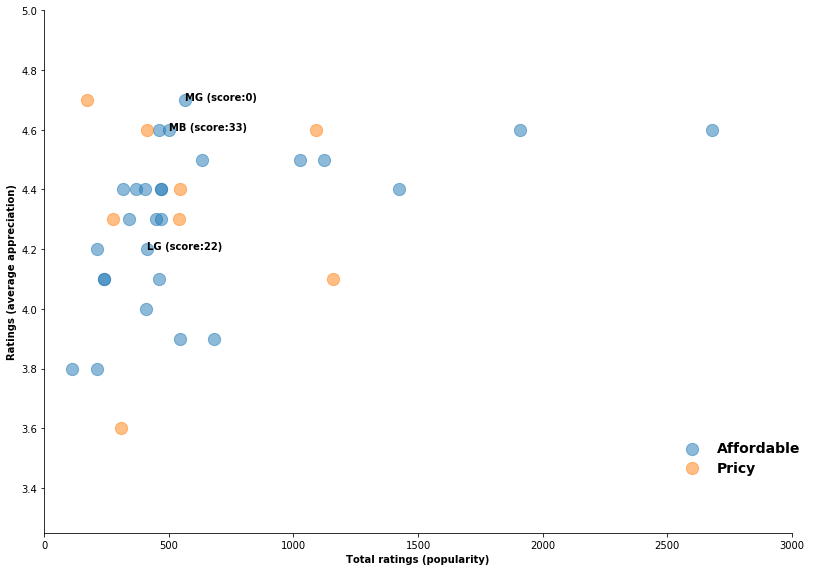

In [404]:
sns.lmplot(data=SBR, x='total_ratings', y='rating', fit_reg=False, scatter_kws={'s':150,'alpha':0.5}, hue='price_range', height=8, aspect=1.4, legend=False)

plt.text(SBR[SBR.full_name.str.contains('mini grill', case=False)].total_ratings, SBR[SBR.full_name.str.contains('mini grill', case=False)].rating, "MG (score:0)", horizontalalignment='left', size='medium', color='k', weight='semibold')
plt.text(SBR[SBR.full_name.str.contains('meat bar', case=False)].total_ratings, SBR[SBR.full_name.str.contains('meat bar', case=False)].rating, "MB (score:33)", horizontalalignment='left', size='medium', color='k', weight='semibold')
plt.text(SBR[SBR.full_name.str.contains('life glasgow', case=False)].total_ratings, SBR[SBR.full_name.str.contains('life glasgow', case=False)].rating, "LG (score:22)", horizontalalignment='left', size='medium', color='k', weight='semibold')

plt.legend(loc=(0.84,0.1), prop={'size':14, 'weight':'semibold'}, frameon=False, labelspacing=0.4)
plt.xlim((0,3000)), plt.ylim(3.25,5)
plt.xlabel('Total ratings (popularity)', weight='semibold'), plt.ylabel('Ratings (average appreciation)', weight='semibold');

Turns out, **'Mini Grill Steakhouse' (MG)**, the place recommended by the blog, did exceptionally well in regards to average ratings, but it scored poorly in what matters the most to Moira (drinks and music). **'Meat Bar' (MB)** on the other hand scored very well (33) and is only marginally lower than **MG** in terms of popularity and average ratings.

Moira is now satisfied, her mind is made up. Let's hope it's not too late to call in and make a reservation!

---

# Historical landmarks in Rome, Italy :

![Rome](https://i.ibb.co/ykQrx4N/rome.png)

Photo by sbmeaper1 - Flickr.com (Public Domain)

Antonio is a high school history teacher. He is planning a 3 days field trip to Rome, the capital of Italy, with a group of his students to see **the most popular historical landmarks** in it. However, knowing how packed Rome is with tourist this time of year, his main concern is to avoid long queues and big crowds while visiting certain locations, especially during **peak hours**. That's why we're going to help him schedule his visit to ensure a maximum level of comfort for his students. 

Same as always, we'll use our code to scrape useful information from Google Maps. This time, we'll add a new kind of info: **popular times** :

![photo](https://i.ibb.co/Hdcx7xC/popular-times.png)

Google Maps shows the graph above when you visit the **Pantheon**'s page (a big former Temple, now Church in Rome). According to Google Maps: **"On the popular times graph, popularity for any given hour is shown relative to the typical peak popularity for the business for the week"**. So visiting the Pantheon on Saturday at 4 PM would be a very bad idea because that's the busiest hour all week (hence 100% on the value for the attribute `aria-label`).

In this case, we won't search around a particular place. We'll simply search Google Maps for **'rome tourist attraction'** (to be as broad as possible). Now let's run our code :

In [49]:
# Make sure to supply the path to where you put the chromedriver.exe file. Use \\ instead of \ :
driver = webdriver.Chrome("C:\\chromedriver.exe")

# This is the list where we'll capture the historical landmarks (names and addresses)
landmarks = []

# [STEP A] : The first search we'll do for 'rome touriste attraction'
url = 'https://www.google.com/maps/search/rome touriste attraction'

# [STEP A] : Opening the search URL. You'll notice a chrome window opening :
driver.get(url)
        
# [STEP C] : We repeat the code below 3 times if we arrive at the end of the navgation list the loop breaks on its own) :
for i in tqdmn(range(2), leave=False, desc='1. Rounding the historical landmarks' ) :
    
    # Waiting for the results to appear :
    WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-result-title")))

    # Capturing the names of the competitors and adding it to our historical landmarks' :
    result_names = [i.text for i in driver.find_elements_by_css_selector('h3[class=section-result-title]')]
    result_addresses = [i.text for i in driver.find_elements_by_css_selector('span[class=section-result-location]')] 
    
    for name, address in zip(result_names, result_addresses) :
        landmarks.append(name + ' ' + address)
        
    # Waiting for the 'Next' button to be visible and then click it. If it's not there anymore, break the loop :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.XPATH, "//*[@id='n7lv7yjyC35__section-pagination-button-next']"))).click()
    except ElementClickInterceptedException :
        break
        
    # Waiting 5 seconds before looping (otherwise we get the error ElementClickInterceptedException). If you get the
    #exception, make it wait for a little longer than 5 seconds :
    time.sleep(5)

# We want to remove any '/' character in the names and addresses in the landmarks list (because they'll break URLs) :
landmarks = [i.replace('/', ' ') for i in landmarks]

# These are the empty lists we will populate with the extracted data :
full_name = []
rating = []
total_ratings = []
landmark_cat = []
description = []
address = []
hours = []
lat = []
long = []
    
# Here's the big loop iterating over the landmarks list :
for landmark in tqdmn(landmarks, leave=False, desc='2. Extracting the data') :
    
    # [STEP D] :
    url = 'https://www.google.com/maps/search/' + landmark
    driver.get(url)

    # Waiting for the name of the landmark to load and be visible. If it fails, skip to next one :
    try :
        WebDriverWait(driver,25).until(EC.visibility_of_element_located((By.CLASS_NAME, "section-hero-header-title-title")))
    except (NoSuchElementException, TimeoutException) as e :
        continue
        
    # [STEP E] : Extracting the data and putting it into the empty lists we defined earlier :
    try:
        full_name.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]').text)
    except NoSuchElementException :
        full_name.append(np.nan)

    try:
        rating.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[1]/span/span').text)
    except NoSuchElementException :
        rating.append(np.nan)

    try:
        total_ratings.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[1]/span[2]/span/span[1]/span[2]/span[1]/button').text)
    except NoSuchElementException:
        total_ratings.append(np.nan)

    try:
        landmark_cat.append(driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[2]/div/div[2]/span[1]/span[1]/button').text)
    except NoSuchElementException:
        landmark_cat.append(np.nan)
    
    try:
        description.append(driver.find_element_by_css_selector('div[class=section-editorial-quote]').text)
    except NoSuchElementException:
        description.append(np.nan
                          )
    try:
        address.append(driver.find_element_by_css_selector('div[data-tooltip="Copy address"]').text)
    except NoSuchElementException :
        address.append(np.nan)

    # Here we capture the popular hours for all 7 days starting with Sunday :
    try:
        hours.append([i.get_attribute('aria-label') for i in driver.find_elements_by_xpath("//*[contains(@aria-label, 'busy at')]")])
    except NoSuchElementException:
        hours.append(np.nan)
        
    try:
        coordinates = driver.find_element_by_css_selector('meta[itemprop=image]').get_attribute('content')
        coordinates = coordinates.split('?center=')[1].split('&zoom=')[0].split('%2C')
        lat.append(coordinates[0])
        long.append(coordinates[1])
    except NoSuchElementException:
        lat.append(np.nan)
        long.append(np.nan)

# Closing the Chrome window
driver.close()

Once done, let's make a dataframe out of the lists with extracted. We'll call it `HL` for Historical landmarks :

In [50]:
HL = pd.DataFrame(data={'full_name':full_name, 'rating':rating, 'total_ratings':total_ratings, 
                        'landmark_category':landmark_cat, 'description':description, 'address':address, 'hours':hours})

In [51]:
HL.head()

,full_name,rating,total_ratings,landmark_category,description,address,hours
0,Piazza Navona,4.7,"(110,654)",Plaza,Elegant square dating from the 1st century A.D...,"Piazza Navona, 00186 Roma RM, Italy",[]
1,Roman Forum,4.7,"(102,401)",Historical place,"Vast excavated area of Roman temples, squares ...","Via della Salara Vecchia, 5/6, 00186 Roma RM, ...","[0% busy at 6 AM., 0% busy at 7 AM., 5% busy a..."
2,Fontana del Pantheon,4.6,(496),Fountain,16th-century fountain commissioned by Pope Gre...,"Piazza della Rotonda, 00186 Roma RM, Italy",[]
3,Spanish Steps,4.5,"(43,257)",Monument,"Steps with irregular butterfly-shaped design, ...","Piazza di Spagna, 00187 Roma RM, Italy",[]
4,Trevi Fountain,4.7,"(253,195)",Fountain,"Aqueduct-fed rococo fountain, designed by Nico...","Piazza di Trevi, 00187 Roma RM, Italy",[]


In [52]:
HL.shape

(40, 7)

As always, let's save/open this dataframe on our machine for later use :

In [53]:
HL.to_csv('historical_landmarks.csv', index=False)

In [46]:
HL = pd.read_csv('historical_landmarks.csv')

If you remember, Antonio wants the group to only visit the most popular attractions because the trip only lasts for 3 days. To select the 10 most popular historical landmarks from `HL`, we need to convert `total_ratings` into a numerical vector :

In [54]:
HL.total_ratings = HL.total_ratings.replace('\(|\)|,', '', regex=True)

In [55]:
HL.total_ratings = HL.total_ratings.astype(float)

Let's make a new dataframe `HL10` containing the top most popular cites from `HL` :

In [56]:
HL10 = HL.sort_values(by='total_ratings', ascending=False).head(10).copy()
HL10

,full_name,rating,total_ratings,landmark_category,description,address,hours
4,Trevi Fountain,4.7,253195.0,Fountain,"Aqueduct-fed rococo fountain, designed by Nico...","Piazza di Trevi, 00187 Roma RM, Italy",[]
9,Colosseum,4.7,241400.0,Historical landmark,Monumental 3-tiered Roman amphitheater once us...,"Piazza del Colosseo, 1, 00184 Roma RM, Italy","[0% busy at 6 AM., 0% busy at 7 AM., 19% busy ..."
17,St. Peter's Basilica,4.8,114156.0,Basilica,Late Renaissance church by architects includin...,"Piazza San Pietro, 00120 Città del Vaticano, V...",[]
20,Piazza Navona,4.7,110700.0,Plaza,Elegant square dating from the 1st century A.D...,"Piazza Navona, 00186 Roma RM, Italy",[]
0,Piazza Navona,4.7,110654.0,Plaza,Elegant square dating from the 1st century A.D...,"Piazza Navona, 00186 Roma RM, Italy",[]
25,Vatican Museums,4.6,103047.0,Art museum,Multiple galleries of classical & Renaissance ...,00120 Vatican City,"[% busy at ., 0% busy at 6 AM., 0% busy at 7 A..."
1,Roman Forum,4.7,102401.0,Historical place,"Vast excavated area of Roman temples, squares ...","Via della Salara Vecchia, 5/6, 00186 Roma RM, ...","[0% busy at 6 AM., 0% busy at 7 AM., 5% busy a..."
14,Piazza del Popolo,4.6,62701.0,Plaza,"Grand, landmark square centered by Rome's olde...","Piazza del Popolo, 00187 Roma RM, Italy","[0% busy at 6 AM., 0% busy at 7 AM., 0% busy a..."
12,Castel Sant'Angelo,4.7,50648.0,Castle,"Circular, 2nd-century castle housing furniture...","Lungotevere Castello, 50, 00193 Roma RM, Italy...","[0% busy at 6 AM., 0% busy at 7 AM., 0% busy a..."
16,Villa Borghese,4.6,48061.0,Park,"Lavish villa designed by Ponzio & Vasanzio, wi...","Piazzale Napoleone I, 00197 Roma RM, Italy","[15% busy at 4 AM., 11% busy at 5 AM., 0% busy..."


Our main concern here is to avoid peak hours when visiting these popular destinations. Let's see how the variable `hours` looks like for the Colosseum for example :

In [62]:
str(list(HL10[HL10.full_name == 'Colosseum'].hours))

"[['0% busy at 6 AM.', '0% busy at 7 AM.', '19% busy at 8 AM.', '48% busy at 9 AM.', '81% busy at 10 AM.', '100% busy at 11 AM.', '95% busy at 12 PM.', '82% busy at 1 PM.', '70% busy at 2 PM.', '59% busy at 3 PM.', '43% busy at 4 PM.', '27% busy at 5 PM.', '16% busy at 6 PM.', '0% busy at 7 PM.', '0% busy at 8 PM.', '0% busy at 9 PM.', '0% busy at 10 PM.', '0% busy at 11 PM.', '0% busy at 6 AM.', '0% busy at 7 AM.', '13% busy at 8 AM.', '32% busy at 9 AM.', '54% busy at 10 AM.', '68% busy at 11 AM.', '67% busy at 12 PM.', '60% busy at 1 PM.', '53% busy at 2 PM.', '43% busy at 3 PM.', '30% busy at 4 PM.', '18% busy at 5 PM.', '10% busy at 6 PM.', '0% busy at 7 PM.', '0% busy at 8 PM.', '0% busy at 9 PM.', '0% busy at 10 PM.', '0% busy at 11 PM.', '0% busy at 6 AM.', '0% busy at 7 AM.', '14% busy at 8 AM.', '33% busy at 9 AM.', '54% busy at 10 AM.', '67% busy at 11 AM.', '68% busy at 12 PM.', '61% busy at 1 PM.', '52% busy at 2 PM.', '42% busy at 3 PM.', '30% busy at 4 PM.', '18% busy at

In our top `HL10` dataframe, `hours` is a list describing how busy any hour is (from 6 AM to 11 PM) for 7 days (from Sunday to Saturday in that order). To make analysis easier, we'll create a new empty dataframe for each one of the 8 places in `HL10` with days as index and hours as columns. To do so, we'll use this custom function :

In [57]:
def visit_planner(place_name) :

    # first we make an empty dataframe out of a list of days as index and a list of hours as columns :
    place_name = pd.DataFrame(index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], \
                              columns=['6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM','3 PM',
                                       '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])    
    
    # and then we return that dataframe
    return place_name

Let's test it with the **Colosseum** :

In [58]:
colosseum = visit_planner('Colosseum')
colosseum

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's populate the `10 AM` column with the values that correspond to it. We'll use RegEx here: first we capture the string `***% busy at 10 AM`, then we capture the numbers in it using `\d+`, and since we have 2 numbers here (the percentage and 10), we select the first one using the indexing `[0]`. Finally we convert the vector to integer :

In [59]:
colosseum['10 AM'] = re.findall('...%.{0,20} 10 AM', str(list(HL10[HL10.full_name=='Colosseum'].hours)))
colosseum['10 AM'] = [ re.findall('\d+', str(i))[0] for i in colosseum['10 AM'] ]
colosseum['10 AM'] = colosseum['10 AM'].astype(int)

In [60]:
colosseum

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Sunday,NaN,NaN,NaN,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Monday,NaN,NaN,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tuesday,NaN,NaN,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wednesday,NaN,NaN,NaN,NaN,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thursday,NaN,NaN,NaN,NaN,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Friday,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saturday,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It worked! Let's apply the same code to all hours in a loop :

In [63]:
for hour in list(colosseum):
    colosseum[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=='Colosseum'].hours)))
    colosseum[hour] = [ re.findall('\d+', str(i))[0] for i in colosseum[hour] ]
    colosseum[hour] = colosseum[hour].astype(int)

In [64]:
colosseum

,6 AM,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,11 PM
Sunday,0,0,19,48,81,100,95,82,70,59,43,27,16,0,0,0,0,0
Monday,0,0,13,32,54,68,67,60,53,43,30,18,10,0,0,0,0,0
Tuesday,0,0,14,33,54,67,68,61,52,42,30,18,10,0,0,0,0,0
Wednesday,0,0,12,26,42,53,55,48,41,34,28,22,15,0,0,0,0,0
Thursday,0,0,12,31,53,67,68,61,54,44,33,21,13,0,0,0,0,0
Friday,0,0,13,33,58,72,73,67,60,49,35,22,13,0,0,0,0,0
Saturday,0,0,18,43,73,94,94,81,68,57,44,30,18,0,0,0,0,0


And now let's visualise this data on a heatmap :

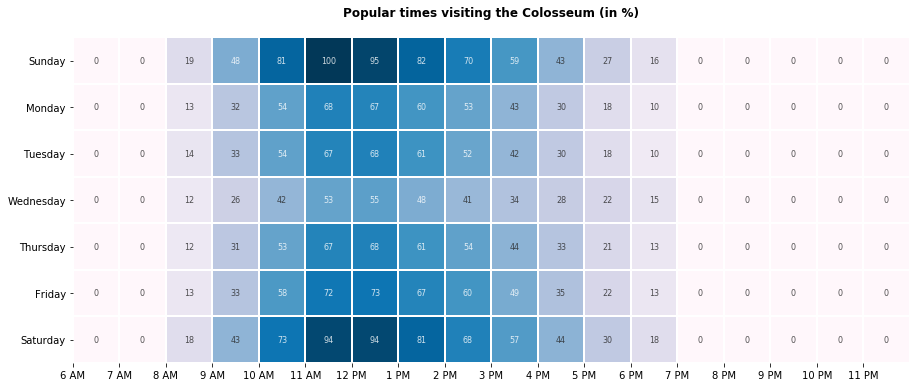

In [65]:
plt.figure(figsize=(15,7))
sns.heatmap(colosseum, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(colosseum))
plt.title('Popular times visiting the Colosseum (in %)\n', weight='semibold')

# this bit of code ensures the heatmap will not show up truncated with some versions of matplotlib
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

If we consider that a rate of around **50%** is comfortable enough for the group (which is half as populous as the busiest hour in the week), and that we need **at least 2 hours** to fully visit a place, the best days and times to visit the Colosseum are :
* **Wednesdays** any hour of the day
* **Mondays**, **Tuesdays** and **Thursdays** from **8AM to 11AM** and from **2PM to 7PM**
* **Fridays** and **weekends** but only from **4PM to 6PM**
* Avoid **Weekends**, especially from **11AM to 2PM**

Let's try the same thing with another place, the **Vatican Museums**. In this case, things are a little bit different because **the place closes on Sundays** and the method we used for the two previews places will not work unless we drop the Sunday row out of the dataframe :

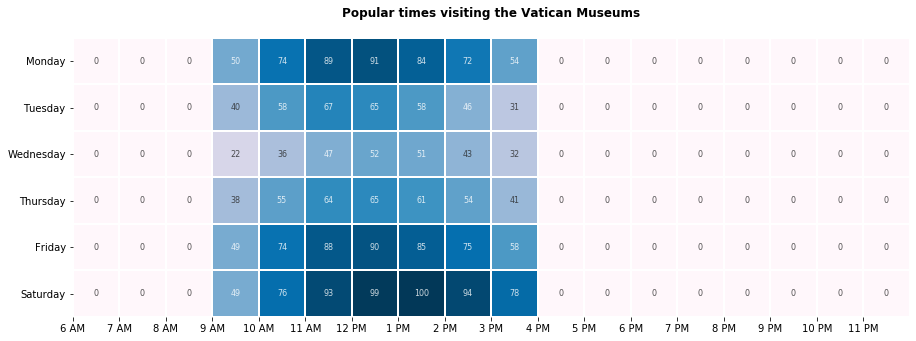

In [66]:
vatican = visit_planner("Vatican Museums")

# we need to remove the row for Sunday before proceeding
vatican.drop('Sunday', axis=0, inplace=True)

for hour in list(vatican):
    vatican[hour] = re.findall('...%.{0,20} '+str(hour), str(list(HL10[HL10.full_name=="Vatican Museums"].hours)))
    vatican[hour] = [ re.findall('\d+', str(i))[0] for i in vatican[hour] ]
    vatican[hour] = vatican[hour].astype(int)

plt.figure(figsize=(15,7))
sns.heatmap(vatican, cmap='PuBu', linewidths=0.8, annot=True, annot_kws={'fontsize':8, 'alpha':0.8}, fmt='d', square=True,
           cbar=False)

plt.xticks(np.arange(18), list(colosseum))
plt.title("Popular times visiting the Vatican Museums\n", weight='semibold')

# this bit of code ensures the heatmap will not show up truncated with some versions of matplotlib
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t);

Now this is a tough one to schedule because we only have a 7 hour window for visits from 9AM to 4PM. So, the best days and times to visit the Vatican Museums are :

* **Wednesdays** all day
* **Tuesdays** from **2PM to 4PM** and **Thursdays** from **9AM to 11AM** and from **2PM to 4PM**
* **Mondays**, **Fridays** and **Saturdays** are to be avoided

Antonio is happy with this newly acquired info. It will help him plan the visit to make the most out of the three days he'll spend with his students in one of the most historically significant cities in Europe.

NB: If you want to try to make a heatmap for a place and you get the errorLength of values does notmatch length of index, make sure the hours list of that place has all the hours from 6 AM to 11 PM (18 in total, repeating 7 times, which makes 126 elements in total). If one or more are missing, try to run the web scraping code again.